## 1. 환경 설정

`(1) Env 환경변수`

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
print(TAVILY_API_KEY[:4])

`(2) 기본 라이브러리`

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from langchain_community.vectorstores import FAISS
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.tools import tool
from langchain_community.tools import TavilySearchResults
from langchain_core.documents import Document

from langchain_openai import ChatOpenAI
from langchain_upstage import UpstageEmbeddings
from langchain_upstage import ChatUpstage

# LangGraph MessagesState라는 미리 만들어진 상태를 사용
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent

from textwrap import dedent
from typing import List, Literal, Tuple
from pydantic import BaseModel, Field

import gradio as gr

from pprint import pprint

import uuid

#from IPython.display import Image, display

## 2. Tool 정의

`(1) 사용자 정의 - @tool decorator`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [ ]:

embeddings_model = UpstageEmbeddings(model="solar-embedding-1-large")

# menu db 벡터 저장소 로드
menu_db = FAISS.load_local(
    "../db/menu_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
from langchain.agents import tool

@tool
def search_menu(query: str) -> List[str]:
    """
    Securely retrieve and access authorized restaurant menu information from the encrypted database.
    Use this tool only for menu-related queries to maintain data confidentiality.
    레스토랑 메뉴에서 정보를 검색합니다.
    """
    
    docs = menu_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

`(2) LangChain 내장 도구`
- 일반 웹 검색을 위한 Tavily 초기화

In [ ]:

# Tool 정의 
from langchain.agents import tool

@tool
def search_web(query: str) -> List[str]:
    """Searches the internet for information that does not exist in the database or for the latest information."""
    
    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

### 2-1. bind_tools() 함수로 LLM과 Tool 연결하기

In [ ]:
from langchain_openai import ChatOpenAI

# LLM 모델 
#llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
)
print(llm.model_name)

# 도구 목록
tools = [search_menu, search_web]

# 모델에 도구를 바인딩 RunnableBindings
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:

# 도구 호출 ( Vector DB )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

In [ ]:
# 도구 호출 ( Tavily )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"최근에 공개된 오픈소스 LLM 모델은 어떤 것들이 있나요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

In [ ]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

In [ ]:
pprint(tool_call)

### 2-2. 도구 노드(ToolNode) 
- AI 모델이 요청한 도구(tool) 호출을 실행하는 역할을 처리하는 LangGraph 콤포넌트
- 작동 방식:
    - 가장 최근의 AIMessage에서 도구 호출 요청을 추출 (반드시, AIMessage는 반드시 tool_calls가 채워져 있어야 함)
    - 요청된 도구들을 병렬로 실행
    - 각 도구 호출에 대해 ToolMessage를 생성하여 반환

`(1) 도구 노드(Tool Node) 정의`



In [ ]:

# 도구 노드 정의 
tools = [search_menu, search_web]
tool_node = ToolNode(tools=tools)

In [ ]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

pprint(tool_call.additional_kwargs)

`(2) 도구 노드(Tool Node) 실행`


In [ ]:
# 도구 호출 결과를 메시지로 추가하여 실행 
# tool_call 변수는 RunnableBinding 객체 (LLM + tool)
results = tool_node.invoke({"messages": [tool_call]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(type(result))
    print(result.content)
    print('**** --------------------------- ****')

In [ ]:
# LLM 모델을 이용하여 도구를 호출하여 실행 
results = tool_node.invoke({"messages": [llm_with_tools.invoke("최근에 공개된 오픈소스 LLM 모델은 어떤 것들이 있나요?")]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print()

## 3. ReAct Agent
- ReAct(Reasoning and Acting) : 가장 일반적인 에이전트
- 동작 방식:
    - 행동 (act): 모델이 특정 도구를 호출
    - 관찰 (observe): 도구의 출력을 모델에 다시 전달
    - 추론 (reason): 모델이 도구 출력을 바탕으로 다음 행동을 결정 (예: 또 다른 도구를 호출하거나 직접 응답을 생성)

- 논문: https://arxiv.org/abs/2210.03629

`(1) LangGraph 내장 ReAct 에이전트 사용`

#### 1-1) create_react_agent() 함수 사용
* create_react_agent() 함수를 사용해서 생성된 agent 를 호출할때 HumanMessage(질문)만 전달

In [ ]:
from IPython.display import Image, display
#from langgraph.prebuilt import create_react_agent

tools = [search_menu, search_web]
graph = create_react_agent(
    llm, 
    tools=tools, 
)

print(type(graph))

graph
# 그래프 출력
#display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)

print(type(messages))

for m in messages['messages']:
    #print(type(m))
    m.pretty_print()

In [ ]:
inputs = {"messages": [HumanMessage(content="최근에 공개된 오픈소스 LLM 모델은 어떤 것들이 있나요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

#### 1-2) create_react_agent() 함수 사용
* create_react_agent() 함수를 사용해서 생성된 agent 를 호출할때 HumanMessage(질문)와 SystemMessage(역할부여) 2개의 메시지를 전달함

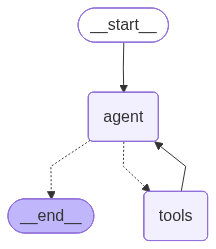

In [37]:
# 시스템 프롬프트
system_prompt = dedent("""
You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크
    
    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question. 
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
Do not provide any information without a corresponding citation.
""")

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
)

# 그래프 출력
#display(Image(graph.get_graph().draw_mermaid_png()))

graph


In [43]:
# 그래프 실행
query = "스테이크 메뉴의 가격은 얼마인가요?"
#query = "최근에 공개된 오픈소스 LLM 모델의 성능을 비교해 주세요?"
#query = "안녕하세요?"
messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=query)
]

# 현재 graph 변수는 내장형 에이전트를 사용하는 Graph
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크

    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니

`(2) 직접 StateGraph객체를 사용해서 tool를 사용하는 Agent 생성하기 ( 내장형 agent를 사용하지 않음 )`
- 조건부 엣지 함수를 사용자 정의
- `should_continue` 함수에서 도구 호출 여부에 따라 종료 여부를 결정
- 도구 실행이 필요한 경우에는 그래프가 종료되지 않고 계속 실행 

In [49]:

# GraphState는 LangGraph의 상태를 정의하는 사용자정의 클래스입니다.
# LangGraph의 MessagesState를 상속받아 메시지 목록을 자동으로 관리합니다.
class GraphState(MessagesState):
    pass

# --- 노드 구성 ---
# call_model 노드는 LLM을 호출하여 응답을 생성합니다.
def call_model(state: GraphState):
    # 시스템 메시지를 정의하여 LLM의 페르소나와 역할을 설정합니다.
    system_message = SystemMessage(content=system_prompt)
    # 기존 메시지 목록 앞에 시스템 메시지를 추가합니다.
    messages = [system_message] + state['messages']
    # 도구 호출 기능이 활성화된 LLM을 호출하여 응답을 받습니다.
    response = llm_with_tools.invoke(messages)
    # LLM의 응답을 상태에 저장하여 반환합니다.
    return {"messages": [response]}

# should_continue 노드는 LLM 응답을 분석하여 다음 단계를 결정하는 라우터 역할을 합니다.
# router 노드 역할을 하는 함수
def should_continue(state: GraphState):
    # 가장 마지막 메시지를 가져옵니다.
    last_message = state["messages"][-1]
    
    # 마지막 메시지에 도구 호출이 포함되어 있으면, "execute_tools" 노드로 이동합니다.
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면, 대화를 종료합니다.
    return END

# --- 그래프 구성 ---
# 상태를 관리하는 그래프를 생성합니다.
builder = StateGraph(GraphState)

# 노드들을 그래프에 추가합니다.
# "call_model": LLM을 호출하여 응답을 받는 노드
builder.add_node("call_model", call_model)

"""
ToolNode는 도구 실행에 필요한 복잡한 로직을 미리 구현해 놓은 래퍼(wrapper) 클래스입니다. 
개발자는 단순히 사용하려는 도구 목록(tools)만 전달하면 됩니다.  
직접 함수를 정의해야 한다면, 각 도구의 이름과 입력 인자를 파싱하고, 해당하는 도구를 찾아 실행하는 코드를 수동으로 작성해야 합니다. 
ToolNode는 이 과정을 자동화하여 코드의 양을 크게 줄여줍니다.
Tool을 호출하는 함수를 개발자가 직접 정의하지 않고, Tool을 호출하는 함수를 LangGraph Node로 만들어 주는 역할
"""
tools = [search_menu, search_web]
builder.add_node("execute_tools", ToolNode(tools))

builder.nodes

{'call_model': StateNodeSpec(runnable=call_model(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.GraphState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'execute_tools': StateNodeSpec(runnable=tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'search_menu': StructuredTool(name='search_menu', description='Securely retrieve and access authorized restaurant menu information from the encrypted database.\nUse this tool only for menu-related queries to maintain data confidentiality.\n레스토랑 메뉴에서 정보를 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.search_menu'>, func=<function search_menu at 0x0000015D86F82AC0>), 'search_web': StructuredTool(name='search_web', description='Searches the internet for information that does not exist in the database or for the latest information.', args_schema=<class 'langcha

<class 'langgraph.graph.state.CompiledStateGraph'>


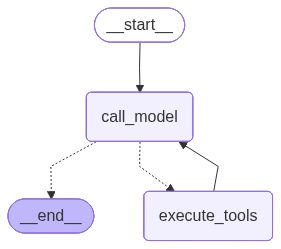

In [50]:

# --- 엣지(연결) 추가 ---
# START에서 "call_model" 노드로 시작합니다.
builder.add_edge(START, "call_model")

# "call_model" 노드에서 'should_continue' 함수를 사용하여 다음 단계를 결정합니다.
builder.add_conditional_edges(
    "call_model",
    should_continue,
    {
        # 'should_continue'가 "execute_tools"를 반환하면, 해당 노드로 이동합니다.
        "execute_tools": "execute_tools",
        # 'should_continue'가 END를 반환하면, 그래프를 종료합니다.
        END: END
    }
)

# "execute_tools" 노드에서 도구 실행 후, ToolMessage결과를 가지고 다시 "call_model" 노드로 돌아갑니다.
# 이는 LLM이 도구의 결과를 보고 최종 응답을 생성하도록 합니다.
builder.add_edge("execute_tools", "call_model")

# 그래프를 컴파일하여 실행 가능한 상태로 만듭니다.
my_graph = builder.compile()
print(type(my_graph))

my_graph
# 그래프 출력 
#display(Image(graph.get_graph().draw_mermaid_png()))

#### Tool를 사용하지 않는 경우 1-> 2-> 3 
* 1. SystemMessage
* 2. HumanMessage
* 3. AIMessage (tool_calls 정보 포함, tool_calls가 비어 있으면 종료)

#### Tool를 사용하는 경우 1-> 2-> 3 -> 4 -> 5
* 1. SystemMessage
* 2. HumanMessage
* 3. AIMessage (tool_calls 정보 포함, tool_calls 정보를 기반으로 Tool을 호출)
* 4. ToolMessage
* 5. AIMessage (최종 결과)

In [51]:
mermaid_code = my_graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	call_model(call_model)
	execute_tools(execute_tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> call_model;
	call_model -.-> __end__;
	call_model -.-> execute_tools;
	execute_tools --> call_model;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph이미지](https://www.mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNptkMsOgjAQRX-lqRtIrA8WLophxSe4U9OUMiNNRiBQEo3x3-UVTKOrzuROz5n2xU2VA5f81ui6YKc0vpQXp1TrdNMfwflYJ0t33NbJNZRSom1aNwwaTaTuPYGCbxkOCTzAdA6UqypqA68LJwWU-SIY6wVPeqIvYiZEwr6C2FczsenjGfI38_Txz3p_8f0SbQrIckDdkWNoieQKI9whrsmWIAqwt8LJ_SbyLoyfM46LqtbGuqfceQPD82ZchtkBDX9_ALpujZU)

In [54]:
# 그래프 실행
#query = "스테이크 메뉴의 가격은 얼마인가요?"
query = "최근에 공개된 오픈소스 LLM 모델의 성능을 비교해 주세요?"
#query = "안녕하세요?"
messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=query)
]
inputs = {"messages": messages}

# my_graph 변수는 직접 StateGraph를 생성하고 노드와 엣지를 추가한 graph
messages = my_graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크

    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니

In [55]:
query = "최근에 가장 많이 사용되는 오픈소스 Javascript 라이브러리들은 어떤 것들이 있나요?"
messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=query)
]
inputs = {"messages": messages}

messages = my_graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크

    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니

`(3) 직접 StateGraph객체를 사용해서 tool를 사용하는 Agent 생성하기 ( 내장형 agent를 사용하지 않음, tools_condition() 함수 )
- LangGraph에서 제공하는 도구 사용을 위한 조건부 엣지 함수  tools_condition 함수 활용하므로 라우터 역할을 하는 함수를 구현하지 않음
- 최신 메시지(결과)가 도구 호출이면 -> `tools_condition`이 도구로 라우팅
- 최신 메시지(결과)가 도구 호출이 아니면 -> `tools_condition`이 `END`로 라우팅

In [56]:
from langgraph.prebuilt import tools_condition
from langgraph.graph import StateGraph, START

# --- 노드 함수 정의 ---
# 'call_model' 노드는 LLM을 호출하여 응답을 생성합니다.
def call_model(state: GraphState):
    # 시스템 프롬프트를 정의하여 LLM의 역할을 설정합니다.
    system_message = SystemMessage(content=system_prompt)
    # 기존 메시지 기록 앞에 시스템 메시지를 추가합니다.
    messages = [system_message] + state['messages']
    # 도구 사용이 가능한 LLM을 호출합니다.
    response = llm_with_tools.invoke(messages)
    # LLM의 응답을 상태에 추가합니다.
    return {"messages": [response]}

# --- 그래프 구성 ---
# 상태를 관리하는 그래프 빌더를 생성합니다.
builder = StateGraph(GraphState)

# 노드들을 그래프에 추가합니다.
# "agent": LLM을 호출하는 노드입니다.
builder.add_node("agent", call_model)
# "tools": 도구 호출을 실행하는 내장 노드입니다.
tools = [search_menu, search_web]
builder.add_node("tools", ToolNode(tools))

builder.nodes

{'agent': StateNodeSpec(runnable=agent(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.GraphState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'tools': StateNodeSpec(runnable=tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'search_menu': StructuredTool(name='search_menu', description='Securely retrieve and access authorized restaurant menu information from the encrypted database.\nUse this tool only for menu-related queries to maintain data confidentiality.\n레스토랑 메뉴에서 정보를 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.search_menu'>, func=<function search_menu at 0x0000015D86F82AC0>), 'search_web': StructuredTool(name='search_web', description='Searches the internet for information that does not exist in the database or for the latest information.', args_schema=<class 'langchain_core.utils.pyda

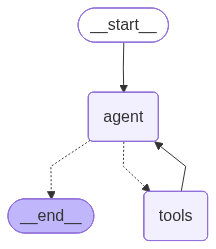

In [57]:

# 그래프의 시작점을 설정합니다.
builder.add_edge(START, "agent")

# 'tools_condition'을 사용한 조건부 엣지 추가
# 이 함수는 LLM 응답에 도구 호출이 포함되어 있는지 자동으로 확인하고,
# 다음 노드를 'tools' 또는 'END'로 결정합니다.
# 별도의 라우팅 함수를 만들 필요가 없어 코드가 간결해집니다.
builder.add_conditional_edges(
    # 현재 노드: "agent" (LLM 응답이 생성된 곳)
    "agent",
    # 라우팅 함수: LangGraph의 'tools_condition'
    tools_condition,
)

# 도구 실행이 끝난 후, 다시 'agent' 노드로 돌아가서
# LLM이 도구의 결과를 보고 최종 답변을 생성하도록 합니다.
builder.add_edge("tools", "agent")

# 그래프를 컴파일하여 실행 가능한 상태로 만듭니다.
my_graph_tc = builder.compile()
my_graph_tc

In [58]:
# 그래프 출력
#display(Image(graph.get_graph().draw_mermaid_png()))

mermaid_code = my_graph_tc.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	agent -.-> __end__;
	agent -.-> tools;
	tools --> agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph이미지](https://mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNpdkc2OgjAQx1-lmb1oAgitAlbjZX2EPe2yMRVaaAItKSVZ1_juW6pLopfpzGT-v_noFUpdcaBQG9Y36OO4K1RhT6fBMuOexde-P8zRftUfvpeUUiHNYKdCVnNlF94up9hq3Q4Lb5d3EFfVjPH-DGnZnTHjURgekGftZjYKI5d8SF_Tvs9u7vuiL12D4cgFqrhgY2uRkG1L3wQWsRBBKxUPGy7rxtIkwk8Cv54vD3XPSmkvNH4qmEZ_4M7inIoSAndAWQEVrB14AB03HZtiuBYKoQJswzteAHXuY5wCCnVzup6pT607oNaMTmn0WDf_wdhXzPKjZO53uhlu3DG4edejskBx4hFAr_ADNHOrZCTGG7JNE7LebgK4AE3WeZSnON_iTU7WGc5vAfz6nnGUZQRnGCcpwXFMsvz2B6g0r_Q)

In [59]:
# 그래프 실행
#inputs = {"messages": [HumanMessage(content="해산물 메뉴에는 어떤 것들이 있나요?")]}

query = "해산물 메뉴에는 어떤 것들이 있나요?"
messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=query)
]
inputs = {"messages": messages}
messages = my_graph_tc.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크

    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니

## 4. MemorySaver

1. 상태의 일시성 문제:
   - 기본적으로 그래프 실행 시 상태는 일시적 (stateless)
   - 그래프를 재실행하는 경우 상태가 초기화되는 문제가 있음 
   - 따라서, 중단이 있는 다중 턴 대화가 어려움 

2. MemorySaver 기능:
   - 가장 쉽게 사용할 수 있는 체크포인터 (각 단계 후 그래프 상태를 자동으로 저장)
   - 그래프 상태를 위한 인메모리 키-값 저장소
   - 지속성(persistence) 있는 메모리 기능을 제공하여 그래프 객체가 체크포인터부터 이어서 실행 가능 

3. 메모리의 필요성:
   - 대화의 연속성: 여러 턴에 걸친 대화를 유지 
   - 중단 허용: 대화 중 중단이 있어도 이전 상태를 복원
   - 유연한 상태 관리: 다양한 대화 스레드를 독립적으로 관리

### 4-1. 사용자 정의 그래프

In [60]:
# 그래프 실행 - 이전 대화 내용을 기억하는지 못하는 문제가 있음 
inputs = {"messages": [HumanMessage(content="이 중에 하나만 추천해주세요.")]}
messages = my_graph_tc.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

이 중에 하나만 추천해주세요.
================================== Ai Message ==================================

질문에 메뉴나 옵션에 대한 구체적인 정보가 제공되지 않았기 때문에 어떤 항목을 추천해야 할지 알 수 없습니다. 추천을 위해 다음 중 하나를 명시해 주세요:  

1. **레스토랑 메뉴 추천**이 필요한 경우:  
   - `search_menu` 함수를 사용해 특정 메뉴(예: "스테이크", "샐러드")를 검색할 수 있습니다.  
   - 예시: *"스테이크 메뉴 중 하나만 추천해 주세요"*  

2. **웹 기반 정보 추천**이 필요한 경우:  
   - `search_web` 함수로 최신 정보(예: "2024년 인기 여행지")를 검색할 수 있습니다.  
   - 예시: *"여름 휴가 추천 장소 중 하나만 알려주세요"*  

필요한 정보를 추가해 주시면 적절한 도구를 사용해 답변드리겠습니다!  

예시 요청 형식:  
- *"[레스토랑 이름]의 파스타 메뉴 중 추천해주세요"*  
- *"[주제]에 대한 최신 트렌드 하나만 알려주세요"*


`MemorySaver 객체사용`
- 체크포인터 지정
- 그래프를 컴파일할 때 Memorysaver 객체를 체크포인터로 지정

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 초기화 
memory = MemorySaver()

# 체크포인터 지정하여 그래프 컴파일 
graph_memory = builder.compile(checkpointer=memory)

print(type(builder))
print(type(memory))
print(type(graph_memory))

`(2) 체크포인터 사용`
- 메모리 사용 시 `thread_id`를 지정 
- 체크포인터는 그래프의 각 단계에서 상태를 기록 (그래프 각 단계의 모든 상태를 컬렉션으로 저장)
- 나중에 `thread_id`를 사용하여 이 스레드에 접근 가능 

In [ ]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

### 4-2. 내장 ReAct 

In [ ]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langchain_core.messages import SystemMessage

# 메모리 초기화 
memory = MemorySaver()

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    #state_modifier=system_prompt,
    checkpointer=memory,
)
graph

In [ ]:

# 그래프 출력
#display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "2"}}

messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="채식주의자를 위한 메뉴가 있나요?")
    ]

messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="방금 답변에 버섯이 포함된 메뉴가 있나요?")]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

## 5. Gradio 챗봇

In [ ]:
import gradio as gr
from typing import List, Tuple
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
import uuid

# MemorySaver를 사용하여 그래프의 상태를 메모리에 저장합니다.
# 이를 통해 이전 대화의 맥락을 기억할 수 있습니다.
memory = MemorySaver()

# builder를 컴파일할 때 'checkpointer'를 설정하여 메모리 기능을 활성화합니다.
graph_memory = builder.compile(checkpointer=memory)

# 예시 질문들입니다. Gradio UI에 미리 표시되어 사용자가 쉽게 챗봇을 테스트할 수 있습니다.
example_questions = [
    "채식주의자를 위한 메뉴를 추천해주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?"
]

# 사용자의 메시지를 처리하고 응답을 생성하는 핵심 함수입니다.
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        # LangGraph의 상태 저장소에 접근하기 위한 설정입니다.
        # "thread_id"는 각 대화 세션을 고유하게 식별하는 데 사용됩니다.
        config = {"configurable": {"thread_id": thread_id}}
        
        # 그래프에 전달할 초기 입력입니다. 사용자의 현재 메시지를 담고 있습니다.
        inputs = {"messages": [HumanMessage(content=message)]}
        
        # 설정된 그래프를 호출하여 전체 워크플로우(예: RAG)를 실행합니다.
        # 'graph_memory'는 이전 대화 상태를 자동으로 불러와서 사용합니다.
        result = graph_memory.invoke(inputs, config=config)
        
        # 결과에 'messages'가 포함되어 있으면 응답을 처리합니다.
        if "messages" in result:
            # 현재 스레드 ID와 메시지들을 출력하여 디버깅에 도움을 줍니다.
            print(f"스레드 ID: {thread_id}")
            for msg in result["messages"]:
                # 메시지를 깔끔한 형식으로 출력합니다.
                msg.pretty_print()

            # 마지막 메시지를 가져옵니다.
            last_message = result["messages"][-1]
            
            # 마지막 메시지가 AI의 응답이면 해당 내용을 반환합니다.
            if isinstance(last_message, AIMessage):
                return last_message.content

        # 응답이 유효하지 않을 경우 반환할 기본 메시지입니다.
        return "응답을 생성하지 못했습니다."

    except Exception as e:
        # 오류 발생 시 오류 메시지를 출력하고, 사용자에게 알립니다.
        print(f"Error occurred: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."

# ChatBot 클래스는 Gradio에 필요한 인터페이스를 제공하고, 각 세션의 thread_id를 관리합니다.
class ChatBot:
    def __init__(self):
        # 챗봇 인스턴스마다 고유한 스레드 ID를 생성합니다.
        self.thread_id = str(uuid.uuid4())

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        # 현재 스레드 ID를 출력하여 확인합니다.
        print(f"Thread ID: {self.thread_id}")
        # 'process_message' 함수를 호출하여 실제 메시지 처리를 위임합니다.
        response = process_message(message, history, self.thread_id)
        return response

# ChatBot 클래스의 인스턴스를 생성합니다.
chatbot = ChatBot()

# Gradio 채팅 인터페이스를 설정하고, 챗봇의 'chat' 메서드를 연결합니다.
demo = gr.ChatInterface(
    fn=chatbot.chat,  # 사용자가 메시지를 입력하면 호출될 함수
    title="레스토랑 메뉴 AI 어시스턴트",
    description="메뉴 정보, 추천, 음식 관련 질문에 답변해 드립니다. 정보의 출처를 함께 제공합니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 애플리케이션을 실행합니다.
demo.launch()

In [ ]:
# 데모 종료
demo.close()